# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
# Pick something you're interested in, not IRX or GSPC

stock_data = yf.download("META", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2022-02-14,219.309998,221.000000,214.779999,217.699997,217.699997,38184000
2022-02-15,220.470001,221.149994,215.059998,221.000000,221.000000,42685500
2022-02-16,212.410004,217.460007,212.360001,216.539993,216.539993,45817500


In [ ]:
scaled_data

array([[-0.10986139],
       [-0.08903905],
       [ 0.03225806],
       ...,
       [-0.02018103],
       [-0.04077762],
       [-0.00746234]])

In [ ]:
train_data

array([[-0.10986139],
       [-0.08903905],
       [ 0.03225806],
       ...,
       [-0.06400131],
       [ 0.05126845],
       [-0.04461528]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################

input_size = 5
# Number of lags, we choose the number of lags we want, ie 5, 10, 15

for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > train_data[i-1, 0]:
      y_train.append(1)
    else:
      y_train.append(0)


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1))
model.add(Dropout(0.5))


# 最後一個LSTM的 return_sequences = False

#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25)) # Dropout percentage # default in ReLU

# Classification : Pick you activation function
# model.add(Dense(1)) 
# Last neuron is classification function

model.compile(optimizer='adam', loss='mean_squared_error', metrics = "accuracy")
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1959/1959 [==============================] - 8s 3ms/step - loss: 0.3731 - accuracy: 0.5142
Epoch 2/3
1959/1959 [==============================] - 5s 3ms/step - loss: 0.3704 - accuracy: 0.5091
Epoch 3/3
1959/1959 [==============================] - 6s 3ms/step - loss: 0.3693 - accuracy: 0.5205


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

### _Biggest differece bewteen LSTM and a normal Perceptron is that the perceptron takes multiple inputs, but only outputs one output. LSTM takes in multiple inputs and and give out multiple outputs._

In [ ]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = []
# y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(1 if train_data[i, 0] > 0 else 0)

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions = model.predict(x_test)



16/16 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model.evaluate(x_train, y_train)

62/62 [==============================] - 1s 2ms/step - loss: 0.2908 - accuracy: 0.5140


[0.2908002734184265, 0.5140377879142761]

In [ ]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 0.2936 - accuracy: 0.5071


[0.2935919463634491, 0.5071282982826233]

In [ ]:
y_test

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [ ]:
# OOS Random Walk model
random_test_pred = y_test[:-1]
random_test_y = y_test[1:]

In [ ]:
# In Random Walk model
random_train_pred = y_train[:-1]
random_train_y = y_train[1:]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(random_test_pred, random_test_y)

0.5040816326530613

In [ ]:
accuracy_score(random_train_pred, random_train_y)

0.33094994892747703

In [ ]:
comp = {"Accuracy": [model.evaluate(x_train, y_train)[1], model.evaluate(x_test, y_test)[1], accuracy_score(random_train_pred, random_train_y), accuracy_score(random_test_pred, random_test_y)], 
     "Metrics": ["In Sample", "Out of Sample", "In Sample", "Out of Sample"],
     "Model": ["RNN", "RNN", "Random Walk", "Random Walk"]}
df = pd.DataFrame(comp)

16/16 [==============================] - 0s 5ms/step - loss: 0.2936 - accuracy: 0.5071


In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='Metrics', ylabel='Accuracy'>

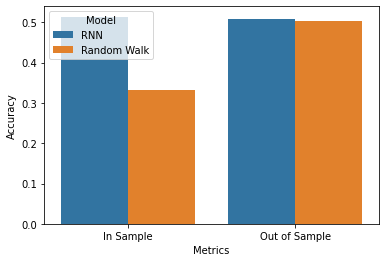

In [ ]:
sns.barplot(y = "Accuracy", x = "Metrics", hue = "Model", data = df)

In [ ]:
### In Random Walk
# y_train[1:] # Actual
# y_train[:-1] # Prediction

### Out of sample Random Walk
# y_test[1:] # Actual
# y_test[:-1] # Prediction

### In sampple accuracy 
# in_sample_predictions = model.predict(x_train)
# in_sample_accuracy = np.mean(np.round(in_sample_predictions) == y_train)

In [ ]:
### In sample Random Walk accuracy 
# in_sample_random_walk_accuracy = np.mean(y_train[1:] == y_train[:-1])

In [ ]:
### Out of sample accuracy
# out_of_sample_predictions = model.predict(x_test)
# out_of_sample_accuracy = np.mean(np.round(out_of_sample_predictions) == y_test)

In [ ]:
### Out of sample Random Walk accuracy
# out_of_sample_random_walk_accuracy = np.mean(y_test[1:] == y_test[:-1])

# Don't Do 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

16/16 [==============================] - 0s 2ms/step


ValueError: ignored

# 5.) Write an observation/conclusion about the graphs from Q4 and Q3
From the graph in Q3, we can see that we are unable to beat the Random Walk. In addition, in-sample accuracy scores tend to be lower than out-sample accuracy scores.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
### Edit here to create your optimizer

# The structure below input-size (the for loop) will need to be in the function
def create_model(neuron):# Add a parameter that will change the number of inputs
   x_train = []
   y_train = []
   for i in range(neuron, len(train_data)):
     x_train.append(train_data[i - neuron:i, 0])
     y_train.append(1 if train_data[i, 0] > 0 else 0)
   x_train, y_train = np.array(x_train), np.array(y_train)
   x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
   model = Sequential()

   model.add(LSTM(x_train.shape[1], return_sequence = True, input_shape = (x_train.shape[0])))
   model.add(Dense(1, activation = 'sigmoid'))
   model.add(Dropout(0.5))
   model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ["accuracy"])
   return(model)

model = KerasRegressor(build_fn = create_model, verbose = 0)

param_grid = {"batch_size": [10, 20, 100], 
        "epochs": [1], 
        "neuron": [5,10,20]}

grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = 3)
grid_result = grid.fit(x_train_arr,y_train_arr)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-55-0b139ebdb9cb>:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = create_model, verbose = 0)


NameError: ignored

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim = 60, activation = 'LSTM'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn = create_model, verbose = 0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {'batch_size': [10, 20, 100], 'epochs': [10, 100], 'neurons':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = 3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
def create_model(input_size):
    # Globally change your inputs
    
    model = Sequential()
    model.add(Dense(10, input_dim=input_size, activation='LSTM'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)